In [4]:
!pip install pytorch-lightning==1.2.3 --quiet

In [5]:
import torchvision
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torchvision.models import vgg16
from torchvision.utils import make_grid

import torch
from torch import nn, optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning.metrics.functional import accuracy


In [6]:
print(pl.__version__)
print(torch.__version__)
print(torchvision.__version__)

1.2.3
1.8.1+cu101
0.9.1+cu101


In [7]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, image_size=32, batch_size=64, test_batch_size= 10000):
        super().__init__()
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size

        self.transform = T.Compose([
              T.Resize(size=image_size),
              T.CenterCrop(size=image_size),
              T.ToTensor(),
        ])
        

    def setup(self, stage=None):
        val_size = 3000
        
        dataset = CIFAR10(root='/', download=True, transform=self.transform)
        test_dataset = CIFAR10(root='/', train=False, transform=self.transform)
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        self.train_data_loader = DataLoader(train_dataset, self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
        self.val_data_loader = DataLoader(val_dataset, self.batch_size, num_workers=4, pin_memory=True)
        self.test_data_loader = DataLoader(test_dataset, self.test_batch_size, num_workers=4, pin_memory=True)


    def train_dataloader(self):
        return self.train_data_loader

    def val_dataloader(self):
        return self.val_data_loader

    def test_dataloader(self):
        return self.test_data_loader

In [16]:
data_module = CIFAR10DataModule(image_size=32)


In [17]:
def display_images(images, total_images_to_display = 64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    images= images.detach()
    images = images[:total_images_to_display]

    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))


Images from validataion dataset


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Images from train dataset
Images from test dataset


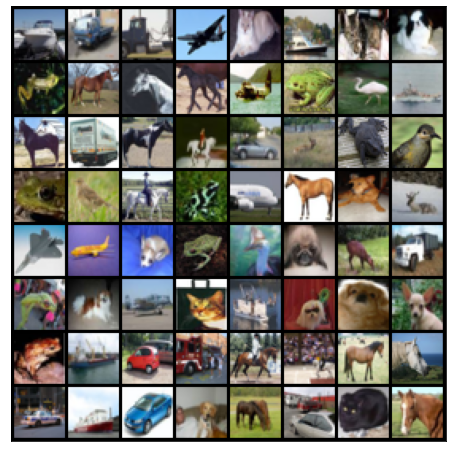

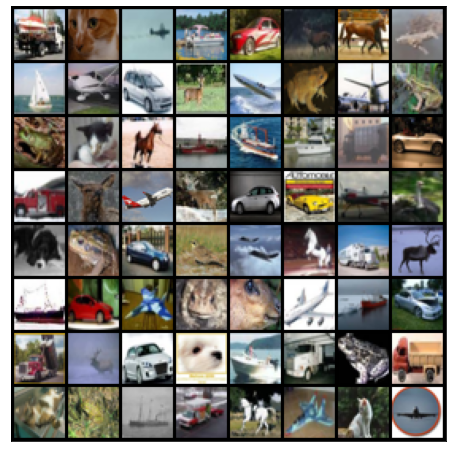

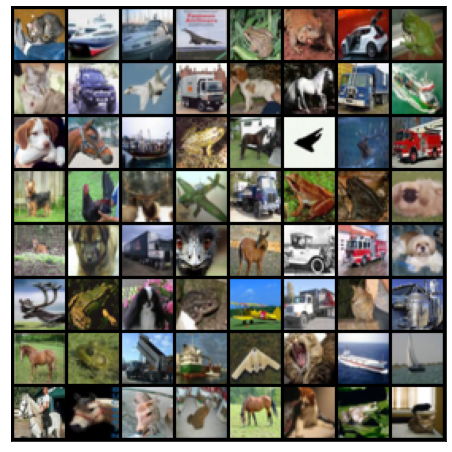

In [25]:
#Images from validataion dataset
for images, _ in data_module.val_dataloader():
  display_images(images)
  break
#Images from train dataset
for images, _ in data_module.train_dataloader():
  display_images(images)
  break
#Images from test dataset
for images, _ in data_module.test_dataloader():
  display_images(images)
  break

In [11]:
class CustomLayer(pl.LightningModule):
  def __init__(self):
        super().__init__()
  
  def forward(self, input):
    return input

In [19]:
#printing VGG-16 architecture
vgg16(pretrained=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
class ImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()
        
        self.pretrain_model = vgg16(pretrained=True)
        self.pretrain_model.eval()
        for param in self.pretrain_model.parameters():
            param.requires_grad = False

        self.pretrain_model.avgpool = nn.Identity()

        self.pretrain_model.classifier = nn.Sequential(
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(256,10),
                                )
        

    def forward(self, input):
        output=self.pretrain_model(input)
        return output

    def training_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs) 
      preds = torch.argmax(outputs, dim=1)
      train_accuracy = accuracy(preds, targets)
      loss = self.loss(outputs, targets)
      self.log('train_accuracy', train_accuracy, prog_bar=True)
      self.log('train_loss', loss)
      return {"loss":loss,}
    
    def validation_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs) 
      preds = torch.argmax(outputs, dim=1)
      val_accuracy = accuracy(preds, targets)
      loss = self.loss(outputs, targets)
      self.log('val_accuracy', val_accuracy, prog_bar=True)
      self.log('val_loss', loss)
      return {"val_loss":loss}
      

    def test_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self.forward(inputs)
      preds = torch.argmax(outputs, dim=1)
      test_accuracy = accuracy(preds, targets)
      loss = self.loss(outputs, targets)
      self.log('test_accuracy', test_accuracy, prog_bar=True)
      print(test_accuracy)
      return {"test_loss":loss, "test_accuracy":test_accuracy}

    def configure_optimizers(self):
      params = self.parameters()
      optimizer = optim.Adam(params=params, lr = self.learning_rate)
      return optimizer



    

In [21]:
model = ImageClassifier()

trainer = pl.Trainer(max_epochs=6, progress_bar_refresh_rate=30, gpus=1)
trainer.fit(model,data_module)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

  | Name           | Type             | Params
----------------------------------------------------
0 | loss           | CrossEntropyLoss | 0     
1 | pretrain_model | VGG              | 14.8 M
----------------------------------------------------
133 K     Trainable params
14.7 M    Non-trainable params
14.8 M    Total params
59.394    Total estimated model params size (MB)


1

In [22]:
trainer.test()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(0.6316, device='cuda:0')

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.631600022315979, 'test_loss': 1.0683900117874146}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.631600022315979, 'test_loss': 1.0683900117874146}]